In [1]:
# Importing python libraries
#
import pandas as pd
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style = 'darkgrid')
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz 
from IPython.display import Image  
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
train_data = pd.read_csv('../notebook/cleaned_train_data.csv')
test_data = pd.read_csv('../notebook/cleaned_test_data.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19372 entries, 0 to 19371
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   19372 non-null  int64  
 1   donated                      19372 non-null  int64  
 2   months_since_origin          19372 non-null  int64  
 3   donor_age                    19372 non-null  float64
 4   in_house                     19372 non-null  int64  
 5   urbanicity                   19372 non-null  object 
 6   ses                          19372 non-null  int64  
 7   cluster_code                 19372 non-null  int64  
 8   home_owner                   19372 non-null  object 
 9   donor_gender                 19372 non-null  object 
 10  income_group                 19372 non-null  float64
 11  published_phone              19372 non-null  int64  
 12  overlay_source               19372 non-null  object 
 13  mor_hit_rate    

In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   2148 non-null   int64  
 1   months_since_origin          2148 non-null   int64  
 2   donor_age                    2148 non-null   float64
 3   in_house                     2148 non-null   int64  
 4   urbanicity                   2148 non-null   object 
 5   ses                          2148 non-null   int64  
 6   cluster_code                 2148 non-null   int64  
 7   home_owner                   2148 non-null   object 
 8   donor_gender                 2148 non-null   object 
 9   income_group                 2148 non-null   float64
 10  published_phone              2148 non-null   int64  
 11  overlay_source               2148 non-null   object 
 12  mor_hit_rate                 2148 non-null   int64  
 13  wealth_rating     

In [5]:
train_data.head()

,Unnamed: 0,donated,months_since_origin,donor_age,in_house,urbanicity,ses,cluster_code,home_owner,donor_gender,...,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,last_gift_amt,card_prom_12,number_prom_12,months_since_last_gift,months_since_first_gift,file_avg_gift,file_card_gift
0,0,0,101,87.0,0,X,5,54,H,M,...,15.0,20.0,5.0,15.0,5,12,26,92,8.49,7
1,1,1,137,79.0,0,R,2,45,H,M,...,20.0,25.0,5.0,17.0,7,21,7,122,14.72,12
2,2,0,113,75.0,0,S,1,11,H,F,...,23.0,28.0,5.0,19.0,11,32,6,105,16.75,16
3,3,0,92,60.0,0,U,2,4,H,F,...,14.0,17.0,3.0,15.0,11,33,6,92,11.76,12
4,4,0,101,74.0,0,R,2,49,U,F,...,20.0,25.0,5.0,25.0,6,19,18,92,8.83,3


In [6]:
train_data.drop("Unnamed: 0", axis=1, inplace=True)
test_data.drop("Unnamed: 0", axis=1, inplace=True)

In [7]:
train_data.head()

,donated,months_since_origin,donor_age,in_house,urbanicity,ses,cluster_code,home_owner,donor_gender,income_group,...,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,last_gift_amt,card_prom_12,number_prom_12,months_since_last_gift,months_since_first_gift,file_avg_gift,file_card_gift
0,0,101,87.0,0,X,5,54,H,M,2.0,...,15.0,20.0,5.0,15.0,5,12,26,92,8.49,7
1,1,137,79.0,0,R,2,45,H,M,7.0,...,20.0,25.0,5.0,17.0,7,21,7,122,14.72,12
2,0,113,75.0,0,S,1,11,H,F,5.0,...,23.0,28.0,5.0,19.0,11,32,6,105,16.75,16
3,0,92,60.0,0,U,2,4,H,F,6.0,...,14.0,17.0,3.0,15.0,11,33,6,92,11.76,12
4,0,101,74.0,0,R,2,49,U,F,2.0,...,20.0,25.0,5.0,25.0,6,19,18,92,8.83,3


In [8]:
test_data.head()

,months_since_origin,donor_age,in_house,urbanicity,ses,cluster_code,home_owner,donor_gender,income_group,published_phone,...,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,last_gift_amt,card_prom_12,number_prom_12,months_since_last_gift,months_since_first_gift,file_avg_gift,file_card_gift
0,101,59.0,0,R,2,46,U,F,5.0,0,...,16.0,21.0,5.0,21.0,4,10,26,90,14.71,2
1,137,59.0,0,R,2,43,U,F,5.0,1,...,9.0,11.0,2.0,10.0,9,22,22,129,6.00,14
2,17,30.0,0,T,1,35,H,M,6.0,1,...,15.0,20.0,5.0,20.0,5,14,20,87,8.44,1
3,137,75.0,0,U,1,2,H,M,6.0,1,...,5.0,10.0,5.0,10.0,10,24,19,129,6.50,22
4,5,59.0,0,T,2,40,U,F,2.0,0,...,7.0,10.0,3.0,5.0,5,12,18,85,5.83,2


In [9]:
train_data.shape, test_data.shape

((19372, 48), (2148, 47))

In [10]:
# Selecting the independent variables and the target variable
#
y = train_data['donated']
X = train_data.drop('donated', axis = 1)


* **Joining the Train and Test data to encode the categorical columns together**

In [11]:
total_data = pd.concat([X, test_data])

In [12]:
categorical_columns = []
for col in total_data.columns:
    unique_column =total_data[col].nunique()
    if unique_column <=60:
        categorical_columns.append(col)

In [13]:
print(categorical_columns)

['months_since_origin', 'in_house', 'urbanicity', 'ses', 'cluster_code', 'home_owner', 'donor_gender', 'income_group', 'published_phone', 'overlay_source', 'wealth_rating', 'pep_star', 'recent_star_status', 'recency_status_96nk', 'frequency_status_97nk', 'recent_card_response_prop', 'recent_response_count', 'recent_card_response_count', 'months_since_last_prom_resp', 'lifetime_card_prom', 'card_prom_12', 'number_prom_12', 'months_since_last_gift', 'file_card_gift']


In [14]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in list(categorical_columns):
        total_data[i]=le.fit_transform(total_data[i])

* **Splitting the Train and Test data to after encoding the categorical columns**

In [15]:
X_train_cat_encoded =  total_data.iloc[:19372]
X_test_cat_encoded =  total_data.iloc[19372:]
X_train_cat_encoded.shape, X_test_cat_encoded.shape

((19372, 47), (2148, 47))

In [16]:
total_data.head()

,months_since_origin,donor_age,in_house,urbanicity,ses,cluster_code,home_owner,donor_gender,income_group,published_phone,...,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,last_gift_amt,card_prom_12,number_prom_12,months_since_last_gift,months_since_first_gift,file_avg_gift,file_card_gift
0,16,87.0,0,5,4,53,0,1,1,0,...,15.0,20.0,5.0,15.0,5,10,22,92,8.49,7
1,27,79.0,0,1,1,44,0,1,6,0,...,20.0,25.0,5.0,17.0,7,19,3,122,14.72,12
2,17,75.0,0,2,0,10,0,0,4,0,...,23.0,28.0,5.0,19.0,11,30,2,105,16.75,16
3,15,60.0,0,4,1,3,0,0,5,1,...,14.0,17.0,3.0,15.0,11,31,2,92,11.76,12
4,16,74.0,0,1,1,48,1,0,1,1,...,20.0,25.0,5.0,25.0,6,17,14,92,8.83,3


In [17]:
# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X_train_cat_encoded, y, test_size = 0.3, random_state = 0)

In [18]:

# define and configure the model
model = KNeighborsClassifier()
# fit the model
model.fit(X_train, y_train)
# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.7019958706125258
The accuracy score is: 0.7019958706125258 and the f1 score is 0.16328502415458937


              precision    recall  f1-score   support

           0       0.75      0.90      0.82      4336
           1       0.28      0.11      0.16      1476

    accuracy                           0.70      5812
   macro avg       0.52      0.51      0.49      5812
weighted avg       0.63      0.70      0.65      5812



array([[3911,  425],
       [1307,  169]], dtype=int64)

In [19]:

# define and configure the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_train, y_train)
# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.6295595320027529
The accuracy score is: 0.6295595320027529 and the f1 score is 0.2854298041818785


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      4336
           1       0.28      0.29      0.29      1476

    accuracy                           0.63      5812
   macro avg       0.52      0.52      0.52      5812
weighted avg       0.63      0.63      0.63      5812



array([[3229, 1107],
       [1046,  430]], dtype=int64)

In [20]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


,importance
feature,
per_capita_income,0.0569
median_home_value,0.0488
pct_attribute4,0.0457
pct_attribute2,0.0445
donor_age,0.0432
pct_owner_occupied,0.0406
median_household_income,0.0392
cluster_code,0.0363
lifetime_gift_amount,0.0347


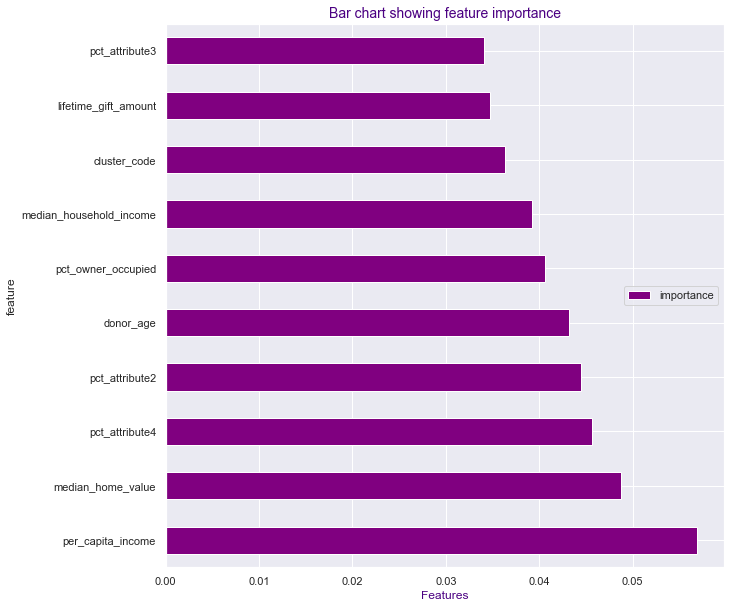

In [21]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [22]:

# define and configure the model
model = XGBClassifier(random_state=43)
# fit the model
model.fit(X_train, y_train)
# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)

[16:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :  0.7231589814177564
The accuracy score is: 0.7231589814177564 and the f1 score is 0.17444843509492047


              precision    recall  f1-score   support

           0       0.76      0.93      0.83      4336
           1       0.36      0.12      0.17      1476

    accuracy                           0.72      5812
   macro avg       0.56      0.52      0.50      5812
weighted avg       0.65      0.72      0.67      5812



array([[4033,  303],
       [1306,  170]], dtype=int64)

In [23]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


,importance
feature,
frequency_status_97nk,0.0807
last_gift_amt,0.0280
file_card_gift,0.0271
number_prom_12,0.0271
recent_card_response_count,0.0262
published_phone,0.0256
card_prom_12,0.0251
pep_star,0.0247
months_since_last_gift,0.0247


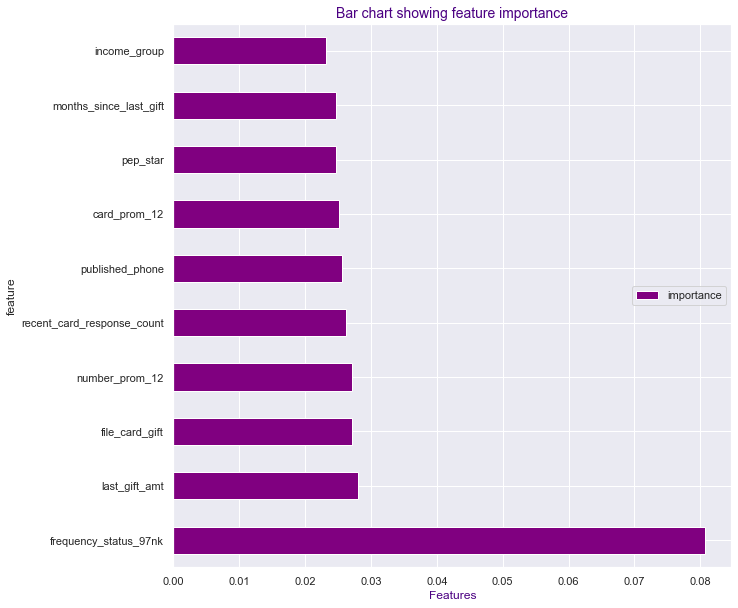

In [24]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [25]:
# define and configure the model
model = CatBoostClassifier(verbose=False)

# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.748107364074329
The accuracy score is: 0.748107364074329 and the f1 score is 0.08955223880597014


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      4336
           1       0.55      0.05      0.09      1476

    accuracy                           0.75      5812
   macro avg       0.65      0.52      0.47      5812
weighted avg       0.70      0.75      0.66      5812



array([[4276,   60],
       [1404,   72]], dtype=int64)

In [26]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df



,importance
feature,
pct_owner_occupied,5.3368
median_home_value,5.3120
donor_age,5.2935
median_household_income,4.3786
per_capita_income,4.0912
pct_attribute4,3.7890
pct_attribute2,3.7308
pct_attribute3,3.6904
cluster_code,3.6761


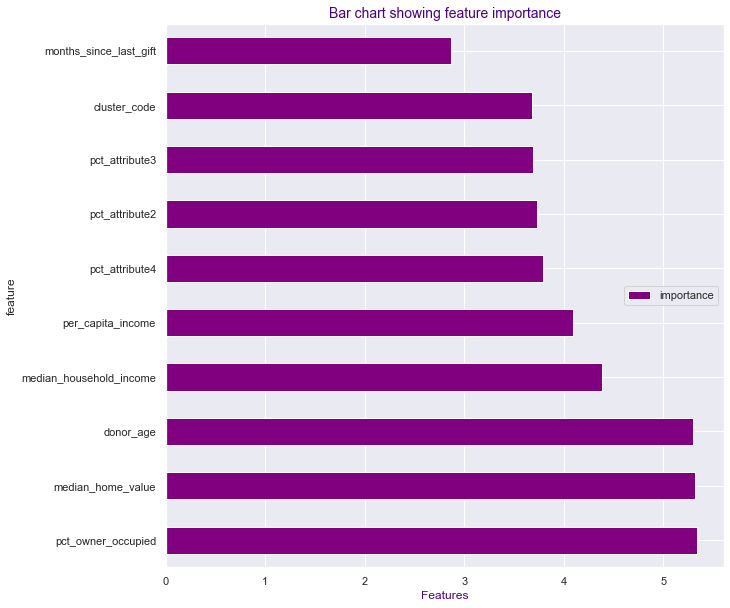

In [27]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [28]:

# define and configure the model
model = LogisticRegression()
# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)

Accuracy :  0.746214728148658
The accuracy score is: 0.746214728148658 and the f1 score is 0.010731052984574111


              precision    recall  f1-score   support

           0       0.75      1.00      0.85      4336
           1       0.53      0.01      0.01      1476

    accuracy                           0.75      5812
   macro avg       0.64      0.50      0.43      5812
weighted avg       0.69      0.75      0.64      5812



array([[4329,    7],
       [1468,    8]], dtype=int64)

In [29]:
# define and configure the model
model = RandomForestClassifier(random_state = 0)

# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


In [ ]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


In [ ]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [ ]:
# define and configure the model
model = AdaBoostClassifier(random_state = 0)

# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


In [ ]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


In [ ]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

# Data Modelling

# Data Modelling

## RandomForest Classifier

### Parameter Tuning

In [ ]:
# Previewing the parameters to tune
#
RandomForestClassifier()

In [ ]:
# Creating a dictionary of parameters to tune
#
params = {'n_estimators': [10, 20, 30, 50, 100],
         'max_depth': [1, 2, 3, 4, 5]}

# Setting the number of folds to 10 and instantiating the model
# 
kfold = KFold(n_splits=10, shuffle=True)
model = RandomForestClassifier()

search = GridSearchCV(model, param_grid=params, scoring = 'f1', cv = kfold)

# Fitting the grid search with the X and the y variables
#
search.fit(X_train_cat_encoded, y)

# Checking for the best parameters
#
print(f'The best parameters are: {search.best_params_}')

In [ ]:
# Applying the best parameters to the model


# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X_train_cat_encoded, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#
rf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state = 0)
rf.fit(X_train, y_train)

# Making predictions
#
y_pred = rf.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)} and the f1 score is {f1_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

*Parameter tuning hasn't decreased or increased the f1 score*

### Cross Validation to check for the stability of the model

In [ ]:
# Performing cross validation of ten folds
#
scores = cross_val_score(rf, X_train_cat_encoded, y, scoring = 'f1', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {scores.mean()}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {scores.std()}')

## Challenging the solution

*Using different models to check whether performance can be improved*

In [ ]:
y__ =  y.copy()
total_test_set_prediction = []
kf = KFold(n_splits=5, random_state=False, shuffle=False)
for train_index, test_index in kf.split(X_train_cat_encoded):
    X_train, X_test = X_train_cat_encoded.iloc[train_index], X_train_cat_encoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_model = RandomForestClassifier(n_estimators=600,random_state=0)

    # fit the model
    rf_model.fit(X_train, y_train)
    # evaluate the model
    preds = rf_model.predict(X_test)
    test_preds  = rf_model.predict(X_test_cat_encoded)
    total_test_set_prediction.append(test_preds)
    #arr = np.stack([arr,test_preds],1)
    y__.iloc[test_index] = preds
    print('k-fold Accuracy : ',accuracy_score(y_test, preds))
print('Cross_validation_Accuracy : ',accuracy_score(y__, y))
test_pred_array = np.array(total_test_set_prediction)
test_pred_array_T = test_pred_array.transpose()
final_test_pred  = mode(test_pred_array_T,1)[0]
final_test_pred = final_test_pred.reshape((-1))


In [ ]:
predicted_donors = pd.DataFrame()
predicted_donors['donated'] = final_test_pred
predicted_donors['control_no'] = test_control_no
predicted_donors.head()

In [ ]:
# Finding the model with the highest accuracy
#
scores.loc['mean'].idxmax()

*An alternative model that can match or outperform the AdaBoostClassifier is the XGBClassifier. More data is needed to increase the predictive power of the model. As the data is highky imbalanced, The f1 score metric of success has been used*

## Conclusion

* *Out of all the models used to predict whether a person has hypothyroid, the AdaBoostClassifier performs well with an f1 score of approximately 86%*


*  *The best performing kernel in the SupportVectorClassifier is Linear with an accuracy score 98.5% of and an f1 score of 86.%*


